<a href="https://colab.research.google.com/github/glouwa/app-kandinsky-pattern-generator/blob/master/kandinsky_in_colab_Datagenerator_from_Frame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs and Files

In [1]:
!rm -r sample_data 
!wget https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py
!wget https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/master/images/parrot_cropped1.jpg

--2019-05-27 00:24:58--  https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py [following]
--2019-05-27 00:24:58--  https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5214 (5.1K) [text/plain]
Saving to: ‘lib.py’

lib.py              100%[===================>]   5.09K  --.-KB/s    in 0s      

2019-05-27 00:24:58 (71.9 MB/s) - ‘lib.py’ saved [5214/5214]

--2019-05-27 00:24:59--  https://github.

In [2]:
from IPython.display import display, SVG
from functools import reduce
from random import seed, randint
from numpy import array, argmax
from google.colab import widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import lib
import PIL

Using TensorFlow backend.


# Intro



## Encoding
X.shape = (samples, 224, 224, 4)

Y.shape = (samples, ?)

for y we can combine multible properies of a sample. 
the output shape is defined by their amount and encodings.


In [3]:
#@title Common Stuff { vertical-output: true } 
image_shape  = (224, 224)
input_shape  = (*image_shape, 3)
output_shape = (6)

print('input_shape', input_shape, 'output_shape', output_shape)

input_shape (224, 224, 3) output_shape 6


In [0]:
max_count       = output_shape
to_onehot       = lambda val, max_int: [1 if val == i else 0 for i in range(max_int)]
fig_path_format = './figures/%s/fig%05d.pkl'
png_path_format = './images/%s/img%05d.png'

import os 
import pickle # import sPickle as pickle

os.makedirs('./figures/', exist_ok=True)
os.makedirs('./images/', exist_ok=True)

def save_figure(path, fid, fig):
    os.makedirs('./figures/%s'%path, exist_ok=True)
    #print("create ir", path)
    dbfile = open(fig_path_format%(path, fid), 'wb+')  
    pickle.dump(fig, dbfile)               
    dbfile.close()  
    #print("saving", fig_path_format%(path, fid))
    
def load_figure(path, fid):
    dbfile = open(fig_path_format%(path, fid), 'rb')  
    fig = pickle.load(dbfile)                      
    dbfile.close()    
    return fig

def load_pil(path, fid):
    img = PIL.Image.open(png_path_format%(path, fid))
    return img.resize(image_shape, PIL.Image.LANCZOS)    

def save_pil(path, fid, pil):
    os.makedirs('./images/%s'%path, exist_ok=True)
    pil.save(png_path_format%(path, fid))

def load_image(path): # used to predict image which are not in sets (like parrot)
    img = PIL.Image.open(path)
    img_resized = img.resize(image_shape, PIL.Image.LANCZOS)    
    return array(img_resized)

count_color = lambda f, c: reduce(lambda a, e: a + (1 if e.color==c else 0), f, 0)
count_shape = lambda f, c: reduce(lambda a, e: a + (1 if e.shape==c else 0), f, 0)

# Sample *s*

In [0]:
figure_config = dict(   
    render_size = image_shape,
    obj_count=(2, 15),     
    obj_size=(.1, .7),
    colors=['red','green', 'blue', 'yellow', 'orange'],
    shapes=['circle']
)

class Sample:  
    def __init__(self, set_path, fid):        
        self.set_path = set_path
        self.fid = fid      
        #print('touching sample %s/%d'%(set_path, fid))
        
        if os.path.isfile(fig_path_format%(set_path, fid)):
            self.f = load_figure(set_path, fid)                                 # schnell
        else:
            self.f = lib.RandomFigure(**figure_config)
            save_figure(self.set_path, self.fid, self.f)                        # nicht so schnell
            
        if os.path.isfile(png_path_format%(set_path, fid)):
            pil = load_pil(self.set_path, self.fid)                             # ok vermutlich
        else:
            pil = lib.kandinskyFigureAsImage(self.f, width=image_shape[0])      # ok
            save_pil(set_path, fid, pil)            
            
        self.x = {            
            'fig': self.f,
            'pil': pil,
            'arr': array(pil)/255,
            #'url': pil.save(path)
        }
        self.y_raw = {
            'pos': 'N() über x⨉y',
            '|*|': len(self.f),
            '|r|': count_color(self.f ,'red'),
            '|g|': count_color(self.f ,'green'),
            '|b|': count_color(self.f ,'blue'),
            '|◯|': count_shape(self.f ,'circle'),
            '|□|': count_shape(self.f ,'rectangle'),
            '|△|': count_shape(self.f ,'trinangle'),
            'viele kleine': True,
            'viele kleine links': True,        
            'x große rote': True,
            'x links von y': True,
            'x über y': True
        }
        self.y = {
            #'encpos': to_onehot(1, 3),
            #'enc|*|': to_onehot(self.y_raw['|*|'], max_count),
            'enc|r|': to_onehot(self.y_raw['|r|'], max_count),
            #'enc|g|': to_onehot(self.y_raw['|g|'], max_count),
            #'enc|b|': to_onehot(self.y_raw['|b|'], max_count),        
            #'enc|◯|': to_onehot(self.y_raw['|◯|'], max_count),
            #'enc|□|': to_onehot(self.y_raw['|□|'], max_count),
            #'enc|△|': to_onehot(self.y_raw['|△|'], max_count),        
            #'|r|>|g|': True,
            #'|r|>|b|': True,
            #'|g|>|r|': False,
            #'|g|>|b|': True,
            #'|b|>|r|': False,
            #'|b|>|g|': False,        
            #'1 großes': True,
            #'1 großes rotes': True,
            #'x links von y': True,
            #'x über y': True,
            #'cap': []
        }    
    def __str__(self):        
        return "%s/I%d"%(self.set_path, self.fid)
    
    def plot(self, verbose=0):                
        fig_str =  '\n'.join([str(f) for f in self.f])
        y_str =    str(self.compileY())
        x_str =    '%s [%.0f…%.0f]'%(self.x['arr'].shape, np.min(self.x['arr']), np.max(self.x['arr']))
        info =     '\n'.join(['%s= %s'%(k, v) for k, v in self.y_raw.items()])
        ex_str =   '\n'.join(['%s= %s'%(k, v) for k, v in self.y.items()])        
        
        plt.imshow(self.x['pil'])        
        plt.title(self)        
        #plt.xlabel('\n'.join([x_str, y_str, fig_str, info, ex_str]))
        if verbose == 0: plt.xlabel('X= %s\nY= %s'%(x_str, y_str))        
        if verbose == 1: plt.xlabel('X= %s\nY= %s\n\n%s\n\n%s'%(x_str, y_str, fig_str, info))        
        if verbose == 2: plt.xlabel('X= %s\nY= %s\n\n%s\n\n%s \n\n%s'%(x_str, y_str, fig_str, info, ex_str))        
        plt.show()
        
    def compileX(self):      
        return self.x['arr']    
    
    def compileY(self):
        #return [ *self.y['enc|*|'], *self.y['enc|r|'] ]
        return [ *self.y['enc|r|'] ]
                
    def compilePandaColumns(self):
        return { 
            **{
                'shape': self.x['arr'].shape, 
                #'path': "%s/%d"%(self.set_path,self.fid),                
                #'X': self.compileX(),
                'file': "img%05d.png"%self.fid,
                'YasStr': '%d red circles'%self.y_raw['|r|']
            },
            **self.y_raw,
            **self.y
        }


,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

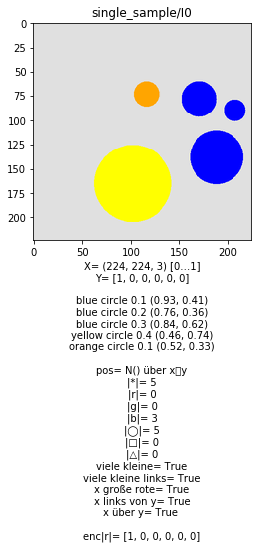

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

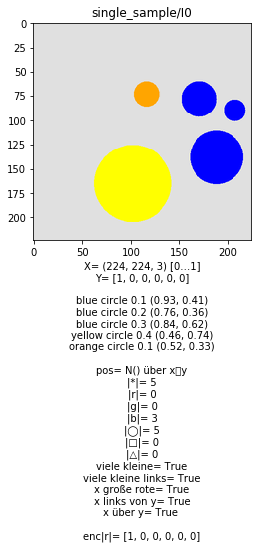

<IPython.core.display.Javascript object>

In [6]:
#@title Create a Sample { vertical-output: true, output-height: 500 }

grid = widgets.Grid(1, 2)
#https://colab.research.google.com/notebooks/widgets.ipynb#scrollTo=P6xc9QVFSlrw

with grid.output_to(0, 0):
    example = Sample('single_sample', 0)
    example.plot(verbose=2)    

with grid.output_to(0, 1):
    example_loaded = Sample('single_sample', 0)
    example_loaded.plot(verbose=2)    

# plot demo
#https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/
#notebooks/04.08-Multiple-Subplots.ipynb




 # Now a Batch of Samples

In [7]:
#@title First Batch { vertical-output: true }
%%time
first_batch_size = 100 #@param {type:"slider", min:1, max:200, step:5}
def generate_batch(set_path, batch_size, batch_index):  
    #print('generating', n_samples)
    X = list()
    y = list()
    c = list()
    for i in range(0, batch_size):
        n = Sample(set_path, batch_index * batch_size + i)
        X.append(n.compileX())
        y.append(n.compileY())        
        c.append(n.compilePandaColumns())    

    return array(X), array(y), pd.DataFrame(data=c)

A, b, f = generate_batch('view_batch', first_batch_size, 0)
#.filter(regex ='^enc.*').head()

display(f.filter(regex='^(?!(enc|X))').head())

,YasStr,file,pos,shape,viele kleine,viele kleine links,x große rote,x links von y,x über y,|*|,|b|,|g|,|r|,|□|,|△|,|◯|
0,2 red circles,img00000.png,N() über x⨉y,"(224, 224, 3)",True,True,True,True,True,10,2,1,2,0,0,10
1,2 red circles,img00001.png,N() über x⨉y,"(224, 224, 3)",True,True,True,True,True,6,2,0,2,0,0,6
2,0 red circles,img00002.png,N() über x⨉y,"(224, 224, 3)",True,True,True,True,True,8,2,1,0,0,0,8
3,3 red circles,img00003.png,N() über x⨉y,"(224, 224, 3)",True,True,True,True,True,9,2,3,3,0,0,9
4,3 red circles,img00004.png,N() über x⨉y,"(224, 224, 3)",True,True,True,True,True,10,2,3,3,0,0,10


CPU times: user 1.85 s, sys: 257 ms, total: 2.1 s
Wall time: 2.12 s


(100, 17)


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7ef5894e0>],
      dtype=object)

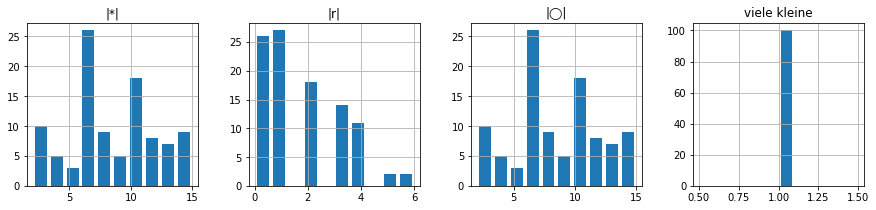

In [8]:
#@title Label Distribution of Batch, using pandaframe *f* { vertical-output: true }

fig = plt.figure(figsize=(15, 3))
print(f.shape)
f.hist(column='|*|',          rwidth=.75, ax=fig.add_subplot(141)) # Divide into a 1x4 grid, give first section
f.hist(column='|r|',          rwidth=.75, ax=fig.add_subplot(142))
f.hist(column='|◯|',          rwidth=.75, ax=fig.add_subplot(143))
f.hist(column='viele kleine', rwidth=.75, ax=fig.add_subplot(144))

# Datagenerator.*renderFrame* returns a panda frame with sample meta info

And cerates the images and figure files

In [0]:
# https://github.com/keras-team/keras/issues/12586
from tensorflow.python.keras.utils.data_utils import Sequence

class DataGenerator(Sequence):
#class DataGenerator(keras.utils.Sequence):  
    'Generates kandinsky data for Keras'
    def __init__(self, set_path="err", samples=1000, batch_size=32, in_dim=None, out_dim=None):        
        self.set_path = set_path
        self.n_samples = samples
        
        self.batch_size = batch_size
        
        self.in_dim = in_dim                
        self.out_dim = out_dim
        
        print('DataGenerator', self.set_path, "samples=", self.n_samples, "batchsize=", self.batch_size, "len=", int(np.floor(self.n_samples / self.batch_size)))
        
    def __len__(self):
        'Denotes the number of batches per epoch'        
        return int(np.floor(self.n_samples / self.batch_size))

    def __getitem__(self, idx): 
        #indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]        
        #ids = ["%d"%k for k in indexes]        
        X, y, f = generate_batch(self.set_path, self.batch_size, idx)                
        return X, y
    
    def renderFrame(self):
        panda = pd.DataFrame()
        for idx in range(len(self)):
            X, y, f = generate_batch(self.set_path, self.batch_size, idx)        
            panda = panda.append(f)    
        print(len(self), self.set_path, "Batches touched")
        #print(panda['file'])
        return self, panda

In [10]:
#@title Data Generators for train/test/val { vertical-output: true }
%%time

batch_size      = 1 #@param {type:"slider", min:1, max:200, step:5}
training_size   = 5000 #@param {type:"slider", min:100, max:20000, step:100}
validation_size = 50 #@param {type:"slider", min:10, max:500, step:10}
test_size       = 100 #@param {type:"slider", min:10, max:500, step:10}
       
params = {
    'batch_size': batch_size,
    'in_dim': input_shape,    
    'out_dim': output_shape
}

training_generator,   panda_train = DataGenerator(set_path="train", samples=training_size, **params).renderFrame()
validation_generator, panda_valid = DataGenerator(set_path="valid", samples=validation_size, **params).renderFrame()
test_generator,       panda_test  = DataGenerator(set_path="test",  samples=test_size, **params).renderFrame()

class_count_of_training_raw = np.max(panda_train['|r|'])
print("Generated class count of training set=", class_count_of_training_raw)

DataGenerator train samples= 5000 batchsize= 1 len= 5000
5000 train Batches touched
DataGenerator valid samples= 50 batchsize= 1 len= 50
50 valid Batches touched
DataGenerator test samples= 100 batchsize= 1 len= 100
100 test Batches touched
Generated class count of training set= 9
CPU times: user 1min 56s, sys: 2.76 s, total: 1min 58s
Wall time: 1min 58s


In [11]:
#@title Second time sould be Faster. (images are already cached) { vertical-output: true }
%%time

training_generator,   _ = DataGenerator(set_path="train", samples=training_size, **params).renderFrame()
validation_generator, _ = DataGenerator(set_path="valid", samples=validation_size, **params).renderFrame()
test_generator,       _ = DataGenerator(set_path="test", samples=test_size, **params).renderFrame()

DataGenerator train samples= 5000 batchsize= 1 len= 5000
5000 train Batches touched
DataGenerator valid samples= 50 batchsize= 1 len= 50
50 valid Batches touched
DataGenerator test samples= 100 batchsize= 1 len= 100
100 test Batches touched
CPU times: user 29.8 s, sys: 842 ms, total: 30.7 s
Wall time: 30.7 s


In [12]:
#@title Label Distribution for Training Set { vertical-output: true }
print(panda_train.shape)
panda_train.filter(regex='^(?!(enc|X|viele kleine links|x links von y|x über y|x große rote))').head()

(5000, 17)


,YasStr,file,pos,shape,viele kleine,|*|,|b|,|g|,|r|,|□|,|△|,|◯|
0,3 red circles,img00000.png,N() über x⨉y,"(224, 224, 3)",True,12,2,2,3,0,0,12
0,2 red circles,img00001.png,N() über x⨉y,"(224, 224, 3)",True,3,0,0,2,0,0,3
0,1 red circles,img00002.png,N() über x⨉y,"(224, 224, 3)",True,7,3,0,1,0,0,7
0,1 red circles,img00003.png,N() über x⨉y,"(224, 224, 3)",True,15,6,2,1,0,0,15
0,3 red circles,img00004.png,N() über x⨉y,"(224, 224, 3)",True,13,2,3,3,0,0,13


(5000, 17)


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7ef2ae908>],
      dtype=object)

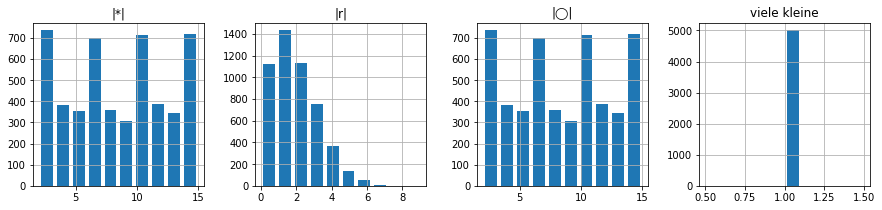

In [13]:
#@title Label/Class Distribution of Training Set { vertical-output: true }

print(panda_train.shape)
panda_train.head()

fig = plt.figure(figsize=(15, 3))
panda_train.hist(column='|*|',          rwidth=.75, ax=fig.add_subplot(141))
panda_train.hist(column='|r|',          rwidth=.75, ax=fig.add_subplot(142))
panda_train.hist(column='|◯|',          rwidth=.75, ax=fig.add_subplot(143))
panda_train.hist(column='viele kleine', rwidth=.75, ax=fig.add_subplot(144))

(4939, 17)
selected 3 colums ['YasStr' 'file' 'enc|r|']


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


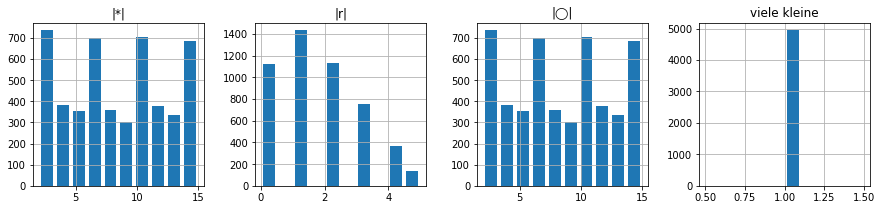

In [14]:
#@title Select Classes { vertical-output: true }

#training_generator.panda = training_generator.panda.astype({"YasStr": str})
#training_generator.panda = training_generator.panda.infer_objects()

select6 = panda_train.loc[panda_train['YasStr'].isin([# ['%d red circles'%i for i in range(0, 5+1)]
    '0 red circles', 
    '1 red circles', 
    '2 red circles', 
    '3 red circles', 
    '4 red circles', 
    '5 red circles'
])]

print(select6.shape)

fig = plt.figure(figsize=(15, 3))
select6.hist(column='|*|',          rwidth=.75, ax=fig.add_subplot(141))
select6.hist(column='|r|',          rwidth=.75, ax=fig.add_subplot(142))
select6.hist(column='|◯|',          rwidth=.75, ax=fig.add_subplot(143))
select6.hist(column='viele kleine', rwidth=.75, ax=fig.add_subplot(144))


select3 = select6[['YasStr', 'file', 'enc|r|']]
print("selected 3 colums", select3.columns.values)

In [15]:
#@title Basic Class Info { vertical-output: true }
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(select3['YasStr']),
    y = select3['YasStr']
)
print(np.unique(select3['YasStr']))
print(class_weight)

['0 red circles' '1 red circles' '2 red circles' '3 red circles'
 '4 red circles' '5 red circles']
[0.73300683 0.57523876 0.72975768 1.09173298 2.23080397 6.14303483]


In [16]:
#@title Data Augmentation and Y Declaration { vertical-output: true }

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

select_keras = select3.sort_values(by=['YasStr'])
select_keras.loc[:,'YasStr'] = select_keras.loc[:,'YasStr'].astype('category')
select_keras.loc[:,'file']   = select_keras.loc[:,'file'].astype(str)

print("select_keras shape=", select_keras.shape)
print("\nselect_keras dtypes=\n", select_keras.dtypes)
print("\nclasses in YasStr=", np.unique(select_keras['YasStr']))

argumented_training_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,    
    zoom_range=[1, 1.5],  
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True
)

training_generator_from_table = argumented_training_generator.flow_from_dataframe(
    dataframe = select_keras,
    directory = './images/train/',
    x_col = 'file',
    y_col = 'YasStr', #'enc|r|', #'|r|', # ja wirklich nicht Y, weil ImageDataGenerator im categorical mode automatisch zu onehot convertiert (wenn man ihm auch die classes gibt?)
    # 'categorical' for string?
    # 'other' for  if Y is int
    class_mode = 'categorical',     
    #classes = ["%d red circles" for i in range(output_shape)],
    batch_size = 10,
    target_size = image_shape,
    shuffle = False
)

training_generator_from_table.batch_size, len(training_generator_from_table)

select_keras shape= (4939, 3)

select_keras dtypes=
 YasStr    category
file        object
enc|r|      object
dtype: object

classes in YasStr= ['0 red circles' '1 red circles' '2 red circles' '3 red circles'
 '4 red circles' '5 red circles']
Found 4939 images belonging to 6 classes.


(10, 494)

Generator: len=494, batch_size=10


,,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

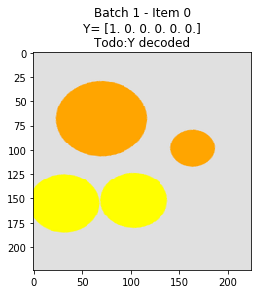

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

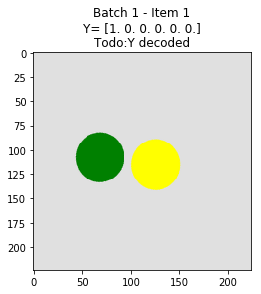

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

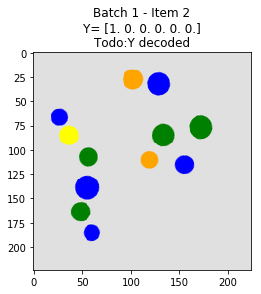

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

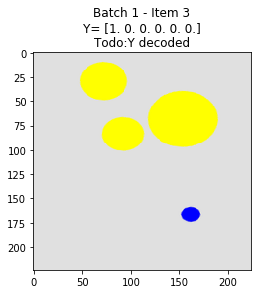

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

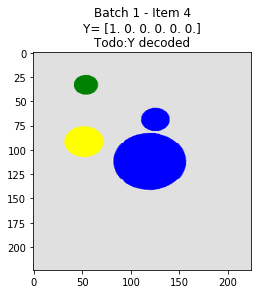

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

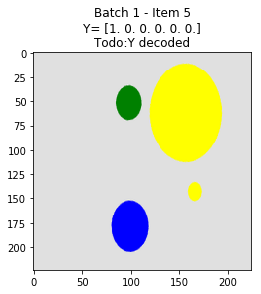

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

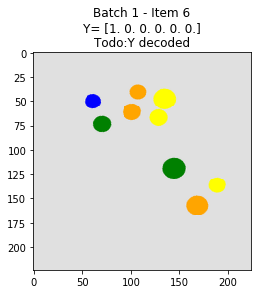

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

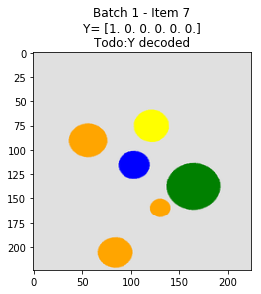

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

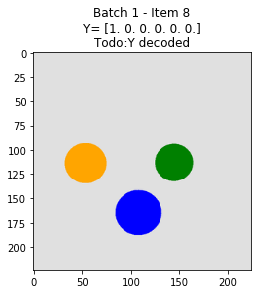

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

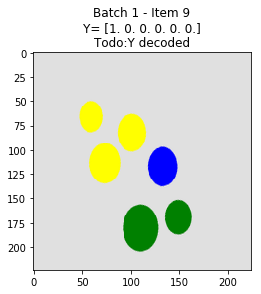

<IPython.core.display.Javascript object>

In [17]:
#@title View Training Selection with Augmentation { run: "auto", vertical-output: true }
batch_to_view = 1 #@param {type:"slider", min:1, max:100, step:3}
batch_view_len = 10 #@param {type:"slider", min:1, max:20, step:1}

print("Generator: len=%d, batch_size=%d"%(len(training_generator_from_table), training_generator_from_table.batch_size))
training_generator_from_table.reset()

X = training_generator_from_table[batch_to_view][0]
Y = training_generator_from_table[batch_to_view][1]

grid = widgets.Grid(1, batch_view_len)
for i in range(batch_view_len):
    with grid.output_to(0, i):        
        plt.title('Batch %d - Item %d\nY= %s\nTodo:Y decoded'%(batch_to_view, i, Y[i]))
        # assert X = Sample(id=batch*batch_size+i).X
        plt.imshow(X[i])
        plt.show()
        
#https://colab.research.google.com/notebooks/widgets.ipynb#scrollTo=P6xc9QVFSlrw


# Data ready :D - Load  VGG16

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 13s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__

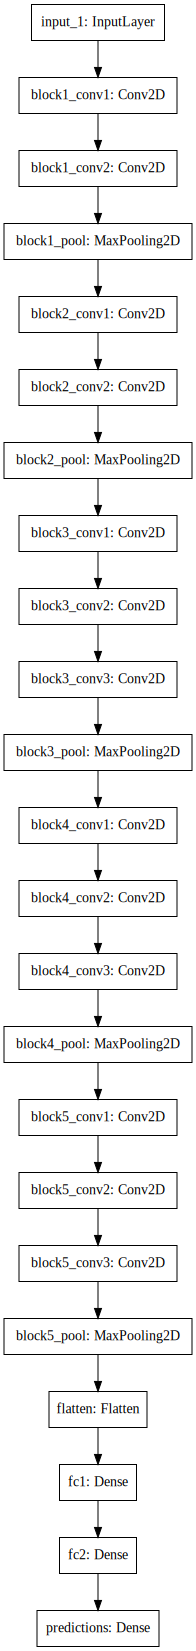

In [18]:
#@title Download VGG16 { vertical-output: true, output-height: 400 }
from tensorflow.python.keras.applications import VGG16

vgg16model = VGG16(include_top=True, weights='imagenet')
vgg16model.summary()
SVG(keras.utils.vis_utils.model_to_dot(vgg16model).create(prog='dot', format='svg'))

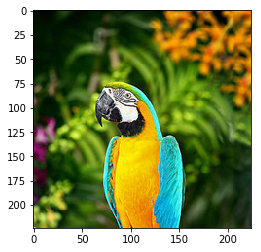

40960/35363 [==================================] - 0s 2us/step
79.02% : macaw
 6.61% : bubble
 3.64% : vine_snake
 1.90% : pinwheel
 1.22% : knot


In [19]:
#@title Make a prediction with vgg16 imagenet weights{ vertical-output: true }
import PIL
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions

def predict(image_array):
    plt.imshow(image_array)
    plt.show()
    
    img_array = np.expand_dims(image_array, axis=0)   
    
    pred = vgg16model.predict(img_array)
    pred_decoded = decode_predictions(pred)[0]
    
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))  
        
predict(load_image('parrot_cropped1.jpg'))
#predict(image_path=image_paths_train[0])

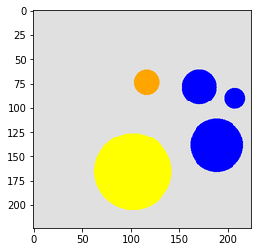

 3.69% : envelope
 3.32% : toilet_tissue
 2.58% : mosquito_net
 1.82% : shower_curtain
 1.45% : toilet_seat


In [20]:
#@title predict a Kandinsky Figure with VGG16 imagenet weights { vertical-output: true }
predict(example.x['arr'])

# Creating a Model: VGG16[0:block5_pool] + 2 new Dense Layers

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 40,411,974
Trainable params: 40,411,974
Non-trainable params: 0
_________________________________________________________________


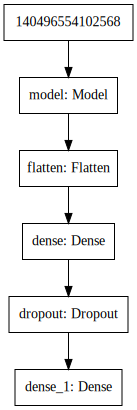

In [21]:
#@title Creating a new Model { vertical-output: true, output-height: 300 }
n1           = 100 #@param {type:"slider", min:1, max:500, step:1}
n2           = 50 #@param {type:"slider", min:1, max:500, step:1}

from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.optimizers import Adam, RMSprop

conv_model = Model(inputs=vgg16model.input, outputs=vgg16model.get_layer('block5_pool').output)

new_model = Sequential()
new_model.add(conv_model)
new_model.add(Flatten())
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(output_shape, activation='softmax'))

new_model.summary()
SVG(keras.utils.vis_utils.model_to_dot(new_model).create(prog='dot', format='svg'))

In [22]:
#@title Compile after trainable Layers are set { vertical-output: true }
optimizer     = "adam"                     #@param ["adam" ,"other"]
learning_rate = 0.01 #@param {type:"slider", min:1e-7, max:0.01, step:1e-3}
loss          = "categorical_crossentropy" #@param ["categorical_crossentropy", "whatever"]
main_metric   = "categorical_accuracy"     #@param ["accuracy", "categorical_accuracy"]
train_vgg16   = False #@param {type:"boolean"}

print(' '.join([str(layer.trainable) for layer in conv_model.layers]), '\n')

conv_model.trainable = train_vgg16
for layer in conv_model.layers: layer.trainable = train_vgg16
    
new_model.compile(optimizer=Adam(lr=1e-5), loss=loss, metrics=[main_metric])

print(' '.join([str(layer.trainable) for layer in conv_model.layers]), '\n')


True True True True True True True True True True True True True True True True True True True 

False False False False False False False False False False False False False False False False False False False 



# Training

In [0]:
#used_generator = training_generator                   # from DataGenerator implementation (files already created, may loads figures and images, but X is transfered in memory)
used_generator = training_generator_from_table         # flow_from_dataframe (from panda frame)
#used_generator = training_generator_from_directory    # flow_from_directory (hvass style)            geht mit tar.gz download oder hier figures generieren

In [0]:
#@title Training { vertical-output: true }
%%time
steps_per_epoch    = 100 #@param {type:"slider", min:10, max:1000, step:1}
epochs             = 5 #@param {type:"slider", min:2, max:50, step:1}
use_multprocessing = True #@param {type:"boolean"}
workers            = 16 #@param {type:"slider", min:1, max:64, step:1}
verbose            = 1 #@param {type:"slider", min:0, max:5, step:1}

history = new_model.fit_generator(    
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,    
    
    generator = used_generator,  
    validation_data = validation_generator,
    
    class_weight = class_weight,
    use_multiprocessing = use_multprocessing,    
    workers = workers,
    verbose = verbose
)

#old_history
#if old_history:
#    old_history = {k, [*old_history[k], *v] for k, v in new_history.items()}
#else:
#    old_history = new_history

lib.plot_history_categorical(history)


Epoch 1/5
206/494 [===========>..................] - ETA: 28:28 - loss: 1.7420 - categorical_accuracy: 0.2782

# Evaluation

In [26]:
#@title Predict Test Set { run: "auto", vertical-output: true }
%%time 

# not working for batchsizes != 1
# assert X from tensorflow is X of sample
# X in the loop is only for that. the pandaframe is sufficient if correct ;)

assert(panda_test.shape[0] == len(test_generator)*test_generator.batch_size)
print('Test set length= ',panda_test.shape[0], "?=", len(test_generator)*test_generator.batch_size)
print("Accuracy %s" % new_model.evaluate_generator(test_generator)[1])

y_pred = new_model.predict_generator(test_generator)

y_pred_nr = np.argmax(y_pred, axis=1)
y_pred_str = ['%d red circles'%nr for nr in y_pred_nr]
print(y_pred_nr)
print("expected\t", panda_test['YasStr'].tolist())
print("predicted\t", y_pred_str)

mask = (panda_test['YasStr'] != y_pred_str)
print("mask\t\t",mask.tolist())
print("number of false predictions", np.sum(mask))

# correct: [numpy.logical_not(mask)] geht ~ auch?
# errors   [mask]
# correct display(panda_test.filter(regex='^(?!(enc|X))')[np.logical_not(mask)])

panda_test['mask'] = mask

col_blacklist = 'enc|X|x über y|x links von y|viele kleine links|viele kleine'

#print("test set:")
#display(panda_test.sort_values(by='file').filter(regex='^(?!(%s))'%col_blacklist))
#print("😄:")
#display(panda_test.sort_values(by='file').filter(regex='^(?!(%s))'%col_blacklist)[mask])
#print("😑:")
#display(panda_test.sort_values(by='file').filter(regex='^(?!(%s))'%col_blacklist)[~mask])






Test set length=  100 ?= 100
Accuracy 0.21
[2 2 1 2 3 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 3 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
expected	 ['1 red circles', '2 red circles', '4 red circles', '4 red circles', '0 red circles', '4 red circles', '0 red circles', '1 red circles', '2 red circles', '2 red circles', '2 red circles', '1 red circles', '0 red circles', '3 red circles', '2 red circles', '1 red circles', '0 red circles', '1 red circles', '0 red circles', '0 red circles', '2 red circles', '3 red circles', '0 red circles', '2 red circles', '2 red circles', '1 red circles', '2 red circles', '3 red circles', '0 red circles', '3 red circles', '1 red circles', '5 red circles', '5 red circles', '1 red circles', '1 red circles', '0 red circles', '0 red circles', '2 red circles', '1 red circles', '0 red circles', '1 red circles', '1 red circles', '1 red circles', '1 red circ

number of false predictions 79
number test samples 100


,,,,,,
,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

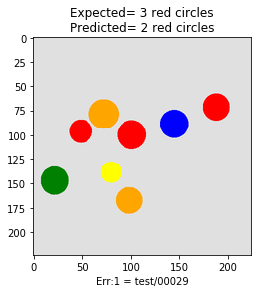

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

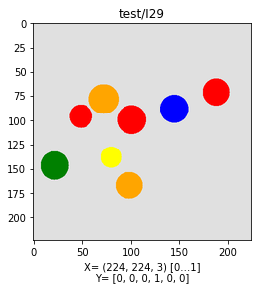

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

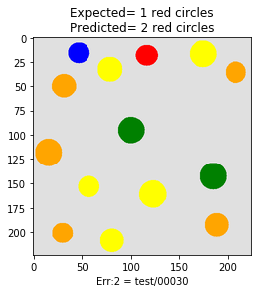

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

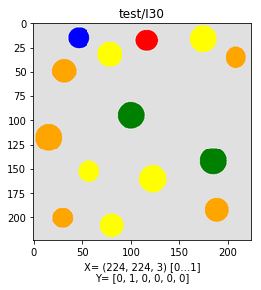

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

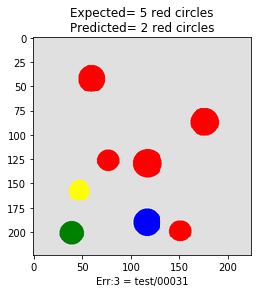

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

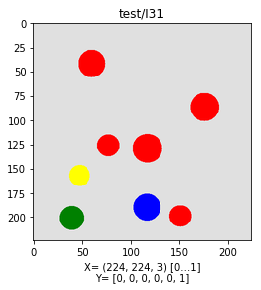

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

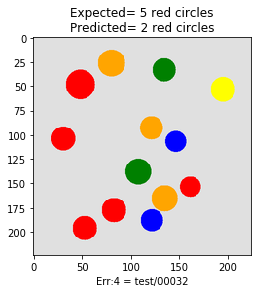

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

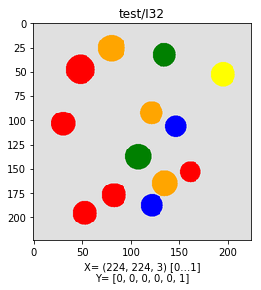

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

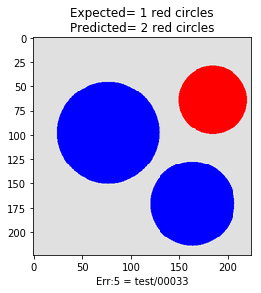

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

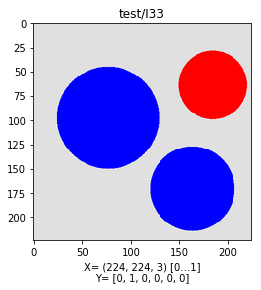

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

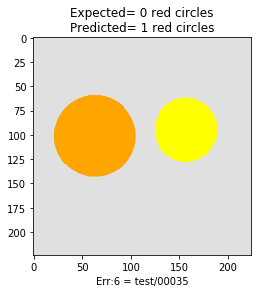

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

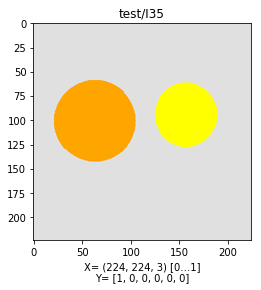

<IPython.core.display.Javascript object>

CPU times: user 3.44 s, sys: 1.76 s, total: 5.2 s
Wall time: 3.26 s


In [27]:
#@title Plot Errors { run: "auto", vertical-output: true }
%%time 

batch_to_view = 29 #@param {type:"slider", min:1, max:100, step:1}
batch_view_len = 6 #@param {type:"slider", min:1, max:20, step:1}
print("number of false predictions", np.sum(mask))
print("number test samples", len(panda_test))

#from ipywidgets import Layout
#items_layout = Layout(width='auto')
grid = widgets.Grid(2, batch_view_len+1)
#gridcell: vertical-align: baseline;

plot_idx = 0
for idx in range(batch_to_view, panda_test.shape[0]):
    X, _ = test_generator[idx] # assuming batch_size = 1        
    
    expected_str = panda_test.iloc[idx]['YasStr']
    predicted_str = y_pred_str[idx]    
    if expected_str != predicted_str:            
        plot_idx = plot_idx + 1        
        with grid.output_to(0, plot_idx):

            #prediction = new_model.predict(X)
            #prediction_str = np.argmax(prediction, axis=1)

            plt.title('Expected= %s\nPredicted= %s'%(expected_str, predicted_str))
            plt.xlabel("Err:%d = test/%05d"%(plot_idx, idx))
            plt.imshow(X[0])
            plt.show()

        with grid.output_to(1, plot_idx):
            Sample('test', idx).plot(verbose=0)
            
    if plot_idx >= batch_view_len:
        break

In [0]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):    
    cm = confusion_matrix(y_true=cls_test, y_pred=cls_pred) 

    print("Confusion matrix:")        
    print(cm)    
    
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [0]:
#https://colab.research.google.com/notebooks/charts.ipynb#scrollTo=8YCVGqZkJJxT

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

In [0]:
from plotly.offline import iplot
import plotly.graph_objs as go

enable_plotly_in_cell()

data = [
    go.Contour(
        z=[[10, 10.625, 12.5, 15.625, 20],
           [5.625, 6.25, 8.125, 11.25, 15.625],
           [2.5, 3.125, 5., 8.125, 12.5],
           [0.625, 1.25, 3.125, 6.25, 10.625],
           [0, 0.625, 2.5, 5.625, 10]]
    )
]
iplot(data)